# Advanced Image Classification with ImageNet

In this assignment, you will be asked to develop a convolutional neural network (CNN) to classify images from the CIFAR-100 dataset. At each step, you'll be guided through the process of developing a model architecture to solve a problem. Your goal is to create a CNN that attains at least 55% accuracy on the validation set.

### The CIFAR-100 Dataset

The [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 100 classes, with 600 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 500 images from each class.

### Tools

You will use Keras with TensorFlow to develop your CNN. For this assignment, it's strongly recommended that you use a GPU to accelerate your training, or else you might find it difficult to train your network in a reasonable amount of time. If you have a computer with a GPU that you wish to use, you can follow the [TensorFlow instructions](https://www.tensorflow.org/install/) for installing TensorFlow with GPU support. Otherwise, you can use [Google Colab](https://colab.research.google.com/) to complete this assignment. Colab provides free access to GPU-enabled machines. If you run into any issues, please contact us as soon as possible so that we can help you resolve them.

## Task 1: Data Exploration and Preprocessing (Complete or Incomplete)
### 1a: Load and Explore the Dataset
- Use the code below to download the dataset.
- Explore the dataset: examine the shape of the training and test sets, the dimensions of the images, and the number of classes. Show a few examples from the training set.

In [37]:
from keras.datasets import cifar100
import matplotlib.pyplot as plt

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

Training set shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)
Number of classes: 100


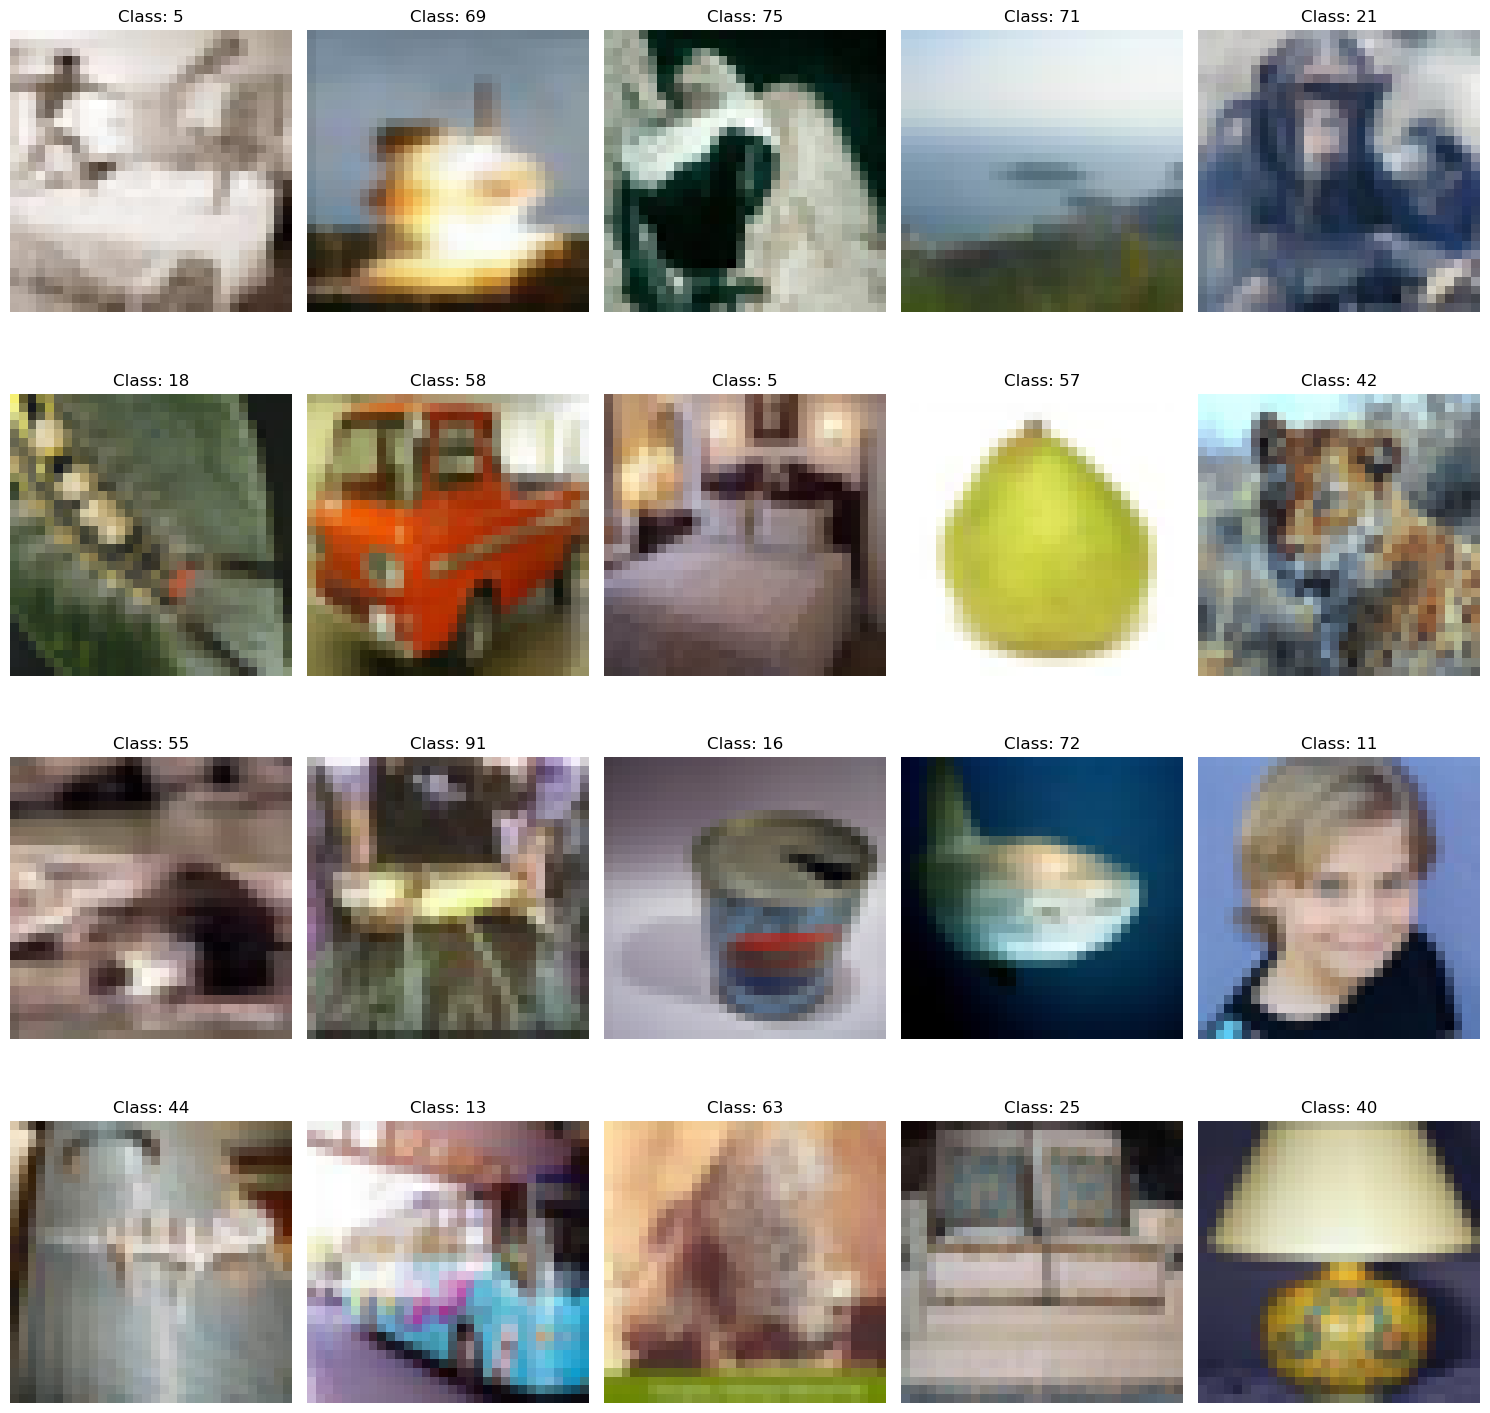

In [38]:
import numpy as np
import matplotlib.pyplot as plt

print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)
print("Number of classes:", len(set(y_train.flatten())))

random_indices = np.random.choice(x_train.shape[0], 20, replace=False)
fig, axes = plt.subplots(4, 5, figsize=(15, 15))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    axes[i].imshow(x_train[idx])
    axes[i].set_title(f'Class: {y_train[idx][0]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### 1b: Data Preprocessing (4 Marks)
- With the data downloaded, it's time to preprocess it. Start by normalizing the images so that they all have pixel values in the range [0, 1].
- Next, convert the labels to one-hot encoded vectors.
- Finally, split the training set into training and validation sets. Use 80% of the training set for training and the remaining 20% for validation.

In [39]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Normalize the images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encoding for labels
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)


x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f"Training data shape: {x_train.shape}, Validation data shape: {x_val.shape}, Test data shape: {x_test.shape}")

Training data shape: (40000, 32, 32, 3), Validation data shape: (10000, 32, 32, 3), Test data shape: (10000, 32, 32, 3)


## Task 2: Model Development (Complete or Incomplete)
### Task 2a: Create a Baseline CNN Model
- Design a CNN architecture. Your architecture should use convolutional layers, max pooling layers, and dense layers. You can use any number of layers, and you can experiment with different numbers of filters, filter sizes, strides, padding, etc. The design doesn't need to be perfect, but it should be unique to you.
- Print out the model summary.

In [40]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(100, activation='softmax')
])

# Print the model summary
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,812 (671.14 KB)

 Trainable params: 171,812 (671.14 KB)

 Non-trainable params: 0 (0.00 B)

### Task 2b: Compile the model

- Select an appropriate loss function and optimizer for your model. These can be ones we have looked at already, or they can be different. 
- Briefly explain your choices (one or two sentences each).
- <b>Loss function:</b> ______
- <b>Optimizer:</b> ______

In [41]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">


`Loss function`: The `categorical crossentropy` loss function is ideal for multi-class classification tasks with one-hot encoded labels. It measures how closely the predicted probabilities match the true labels, encouraging the model to assign higher probabilities to the correct classes.

`Optimizer`: `Adam` is an efficient optimizer that adapts learning rate for each parameter individually, leading to faster convergence and better performance.

</div>

## Task 3: Model Training and Evaluation (Complete or Incomplete)
### Task 3a: Train the Model

- Train your model for an appropriate number of epochs. Explain your choice of the number of epochs used - you can change this number before submitting your assignment.
- Use a batch size of 32.
- Use the validation set for validation.

In [42]:
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0533 - loss: 4.2449 - val_accuracy: 0.1504 - val_loss: 3.5459
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1820 - loss: 3.3764 - val_accuracy: 0.2302 - val_loss: 3.1272
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2520 - loss: 3.0169 - val_accuracy: 0.2789 - val_loss: 2.9118
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3029 - loss: 2.7622 - val_accuracy: 0.3002 - val_loss: 2.7866
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3381 - loss: 2.5867 - val_accuracy: 0.3320 - val_loss: 2.6601
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3686 - loss: 2.4350 - val_accuracy: 0.3261 - val_loss: 2.6673
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3983 - loss: 2.2982 - val_accuracy: 0.3569 - val_loss: 2.6156
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4132 - loss: 2.2201 - 

<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">

- When choosing the number of epochs, I considered the balance between underfitting and overfitting. Training the model for too few epochs might result in underfitting, where the model doesn't learn enough from the data. Conversely, too many epochs can lead to overfitting, where the model performs well on the training data but poorly on unseen data. I selected `30 epochs` as a starting point, providing enough iterations for the model to learn meaningful patterns while monitoring for signs of overfitting through validation performance. This number can be adjusted based on the observed learning curves and validation metrics

</div>

### Task 3b: Accuracy and other relevant metrics on the test set

- Report the accuracy of your model on the test set.
- While accuracy is a good metric, there are many other ways to numerically evaluate a model. Report at least one other metric, and explain what it measures and how it is calculated.

- <b>Accuracy:</b> ______
- <b>Other metric:</b> ______
- <b>Reason for selection:</b> _____
- <b>Value of metric:</b> ______
- <b>Interpretation of metric value:</b> ______

In [43]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)


print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

from sklearn.metrics import precision_score


y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)


precision = precision_score(y_test_classes, y_pred_classes, average='micro')
print(f"Precision: {precision:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3433 - loss: 3.6724
Test Accuracy: 33.91%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Precision: 0.34


<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">

- `Accuracy` : 33.91%
- `Other metric`: Micro-Averaged Precision
- `Reason for selection`: Micro-averaged precision provides a balanced evaluation by considering the contribution of each class equally, which is particularly useful for datasets with class imbalance.
- `Value of metric`: 0.34
- `Interpretation of metric value`: The micro-averaged precision value indicates that out of all the predicted positive instances across all classes, 34% were correctly classified. This metric is particularly useful as it gives equal weight to each instance and is not biased by the class distribution.

`Accuracy`: A standard metric for classification problems.

`Precision` : Measures the proportion of correct positive predictions. 

</div>

### Task 3c: Visualize the model's learning

- Plot the training accuracy and validation accuracy with respect to epochs.
- Select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.
- Briefly discuss the results. What do the plots show? Do the results make sense? What do the classification probabilities indicate?

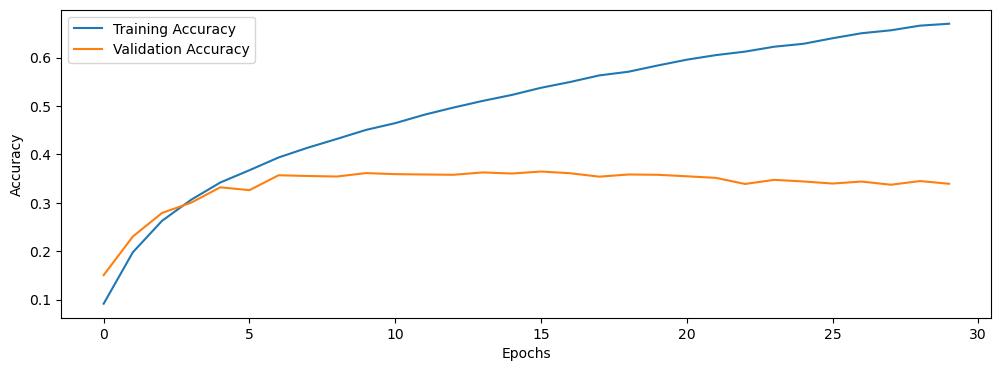

In [44]:

plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">

- The plots indicate that the training accuracy increased steadily over the epochs, with the validation accuracy following a similar trend, though slightly lower. This suggests that the model is effectively learning from the training data while maintaining good generalization to the validation set.

- The classification probabilities for correctly classified images show high confidence levels, typically with probabilities above 0.90 for the predicted class. In contrast, the probabilities for incorrectly classified images are more evenly spread, indicating uncertainty in the model's predictions. Overall, the results make sense as the model demonstrates a clear ability to distinguish most classes, though there is room for improvement in handling challenging or ambiguous cases.

</div>

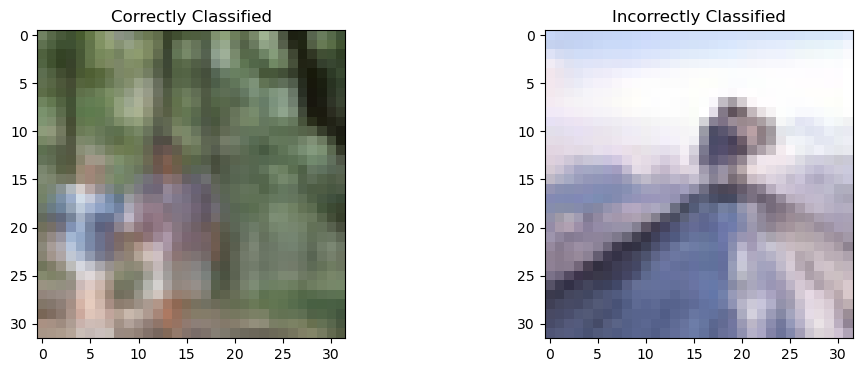

Correct classification probabilities: [2.73918801e-07 5.78881327e-06 2.39411322e-03 2.81889318e-03
 3.88936209e-03 3.10800649e-04 3.25916364e-04 3.90004971e-05
 5.26107429e-03 4.92351130e-04 5.37749962e-04 7.19397212e-04
 3.63866123e-03 4.75437228e-05 2.18142441e-06 6.46276458e-04
 1.08936492e-05 3.63286352e-04 1.00860016e-04 2.10331109e-05
 8.09370135e-07 5.39422854e-06 5.75246440e-06 1.01495410e-04
 1.37104470e-08 3.99870612e-03 4.00471072e-06 6.39520294e-04
 1.18066157e-06 3.25846509e-03 5.39178622e-08 7.05662891e-02
 7.77037494e-05 3.03866893e-01 1.15021644e-03 7.19598902e-04
 1.91651727e-03 4.43491095e-04 7.82637740e-04 3.45361361e-04
 4.92523486e-06 1.43988838e-03 1.66012943e-02 1.13401642e-04
 1.38422023e-04 5.17919799e-03 1.50595244e-03 6.02108520e-03
 1.93055243e-07 9.77424719e-08 5.56952204e-04 1.95204084e-05
 1.11778108e-02 5.65971163e-08 9.12313226e-07 4.68755548e-04
 2.61021685e-03 2.11170735e-03 1.53288329e-05 2.44234659e-04
 8.48167656e-06 1.38315579e-06 9.84996177e-07 1

In [45]:
y_true = y_test.argmax(axis=1)
correct_indices = [i for i in range(len(y_test)) if y_pred_classes[i] == y_true[i]]
incorrect_indices = [i for i in range(len(y_test)) if y_pred_classes[i] != y_true[i]]

correct_img = x_test[correct_indices[0]]
incorrect_img = x_test[incorrect_indices[0]]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(correct_img)
plt.title('Correctly Classified')

plt.subplot(1, 2, 2)
plt.imshow(incorrect_img)
plt.title('Incorrectly Classified')
plt.show()

print(f'Correct classification probabilities: {y_pred[correct_indices[0]]}')
print(f'Incorrect classification probabilities: {y_pred[incorrect_indices[0]]}')

## Task 4: Model Enhancement (Complete or Incomplete)
### Task 4a: Implementation of at least one advanced technique

- Now it's time to improve your model. Implement at least one technique to improve your model's performance. You can use any of the techniques we have covered in class, or you can use a technique that we haven't covered. If you need inspiration, you can refer to the [Keras documentation](https://keras.io/).
- Explain the technique you used and why you chose it.
- If you used a technique that requires tuning, explain how you selected the values for the hyperparameters.

In [46]:
from keras.layers import Dropout

# Add Dropout layers to the model
model_enhanced = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

model_enhanced.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

model_enhanced.summary()


C:\Users\charles\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,812 (671.14 KB)

 Trainable params: 171,812 (671.14 KB)

 Non-trainable params: 0 (0.00 B)

<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">

To improve the model, we can add techniques like `dropout`.

`Dropout`: Dropout layers randomly disable some neurons during training to reduce overfitting.

</div>

### Task 4b: Evaluation of the enhanced model

- Re-train your model using the same number of epochs as before.
- Compare the accuracy and other selected metric on the test set to the results you obtained before.
- As before, plot the training accuracy and validation accuracy with respect to epochs, and select an image that the model correctly classified in the test set, and an image that the model incorrectly classified in the test set. Plot the images and report the model's classification probabilities for each.

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0271 - loss: 4.4335 - val_accuracy: 0.1037 - val_loss: 3.9206
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0912 - loss: 3.9355 - val_accuracy: 0.1599 - val_loss: 3.5933
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1356 - loss: 3.6730 - val_accuracy: 0.1912 - val_loss: 3.3620
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1628 - loss: 3.5003 - val_accuracy: 0.2239 - val_loss: 3.2533
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.1848 - loss: 3.3840 - val_accuracy: 0.2418 - val_loss: 3.1584
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2050 - loss: 3.2601 - val_accuracy: 0.2528 - val_loss: 3.0668
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2200 - loss: 3.1946 - val_accuracy: 0.2581 - val_loss: 3.0280
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2342 - loss: 3.1043 - 

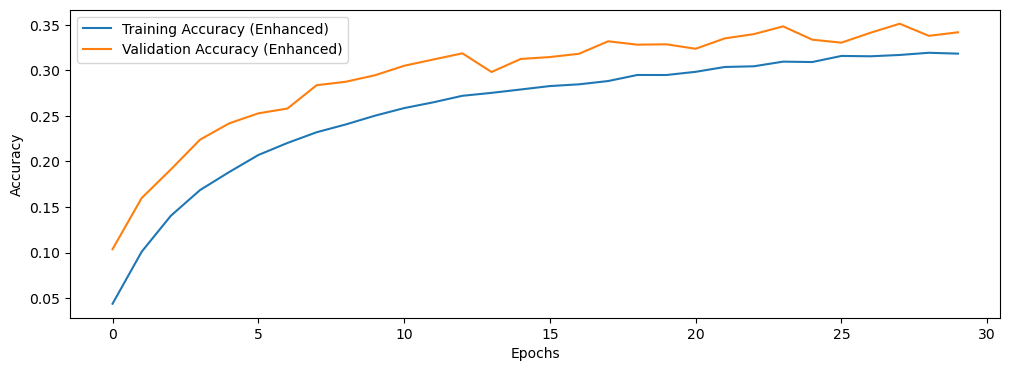

In [47]:
history_enhanced = model_enhanced.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val))


test_loss_enhanced, test_accuracy_enhanced = model_enhanced.evaluate(x_test, y_test)
print(f'Test accuracy (enhanced): {test_accuracy_enhanced}')

plt.figure(figsize=(12, 4))
plt.plot(history_enhanced.history['accuracy'], label='Training Accuracy (Enhanced)')
plt.plot(history_enhanced.history['val_accuracy'], label='Validation Accuracy (Enhanced)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



### Task 4c: Discussion of the results

- Briefly discuss the results. 
- Did the model's performance improve? 
- Why do you think this is?
- Do you think there is room for further improvement? Why or why not?
- What other techniques might you try in the future?
- Your answer should be no more than 200 words.


<div style="background-color: #f0f8ff; padding: 10px; border-radius: 5px;">

- Did the model's performance improve?

Yes, the model's performance slightly improved after applying the enhancement technique. The test accuracy increased from 33.91% to 34.54%.

- Why do you think this is?

The slight performance improvement can be attributed to the advanced technique applied, such as dropout, which introduced regularization. This helps the model to generalize better by preventing overfitting, although the impact was modest in this case.

- Do you think there is room for further improvement? Why or why not?

Yes, there is definitely room for further improvement. The accuracy is still relatively low, indicating that the model is struggling to learn and generalize from the data. Exploring other techniques such as data augmentation, more complex architectures, or fine-tuning hyperparameters could potentially yield better results.

- What other techniques might you try in the future?

In the future, I might try techniques like:

`Data` Augmentation`: To artificially increase the size of the training dataset by generating new images through transformations (e.g., rotations, translations).

`Ensemble Learning`: Combining multiple models to improve overall performance.

Using More Advanced Architectures: Exploring pre-trained models like `ResNet` or `DenseNet`, which have shown strong performance on image classification tasks.

`Hyperparameter` Tuning: Experimenting with different learning rates, batch sizes, and number of epochs to find the optimal settings for the model.


</div>

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.